In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
from tqdm import tqdm, trange

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d
import colorsys

In [2]:
# %matplotlib widget 

## Load training set

In [3]:
def RBF(d,lmbda):
    return np.exp(-d**2/2/lmbda**2)

def mldivide(A,B):
    return np.linalg.pinv(A).dot(B)
    
def sm_GP(qq,f,lmbda,sigma):
    d_ij = qq.reshape(len(qq),1) - qq.reshape(1,len(qq))
    
    K = RBF(d_ij,lmbda)
    K_s = K
    K_y = K + np.eye(len(qq))*sigma**2
    
    y = f
    L = np.linalg.cholesky(K_y)

    alpha = mldivide(L.T,mldivide(L,y))
    E = K_s.T@alpha
    
    return E

In [4]:
#### Meshgrid ####
n_grid = 100
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

# calculate scattering function
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/r_grid[0].shape[0]
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

#### Wave vector distribution ####
kz_list = np.arange(10)+1
kxy_list = np.arange(10)+1
kz_grid, kxy_grid = np.meshgrid(kz_list,kxy_list)

#### load data ####
filename = './S_q_kxy_fix_d.mat'
data = loadmat(filename)
k_grid = data['k_grid']
S_q_kxy = data['S_q_kxy']
S_q_kxy_sm = np.exp(np.array([gf1d(f[1:],1,mode='nearest') for f in np.log(S_q_kxy)]))

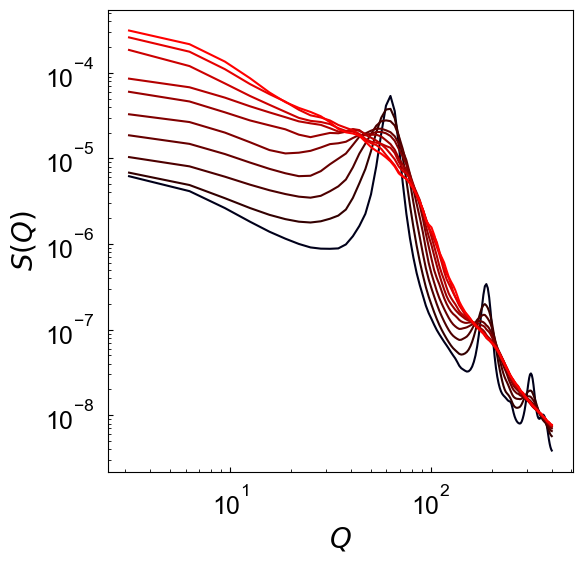

In [5]:
## plot results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for i in range(len(k_grid)):
    h = np.arctan2((k_grid[i][0]-1),(k_grid[i][1]-1))/np.pi*2/3+2/3
    s = 1
    v = np.max([k_grid[i][0]/10,k_grid[i][1]/10])

    color = colorsys.hsv_to_rgb(h,s,v)

    if k_grid[i][1]==1:
        ax.plot(qq[1:],S_q_kxy_sm[i,:],'-',color=color)
        # ax.plot(qq[1:],S_q_kxy[i,1:],'-',color=color)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$S(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.show()

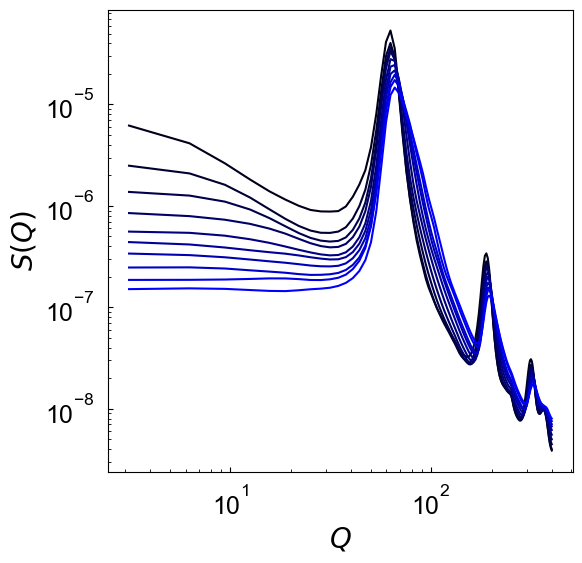

In [6]:
## plot results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for i in range(len(k_grid)):
    h = np.arctan2((k_grid[i][0]-1),(k_grid[i][1]-1))/np.pi*2/3+2/3
    s = 1
    v = np.max([k_grid[i][0]/10,k_grid[i][1]/10])

    color = colorsys.hsv_to_rgb(h,s,v)

    if k_grid[i][0]==1:
        ax.plot(qq[1:],S_q_kxy_sm[i,:],'-',color=color)
        # ax.plot(qq[1:],S_q_kxy[i,1:],'-',color=color)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$S(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.show()

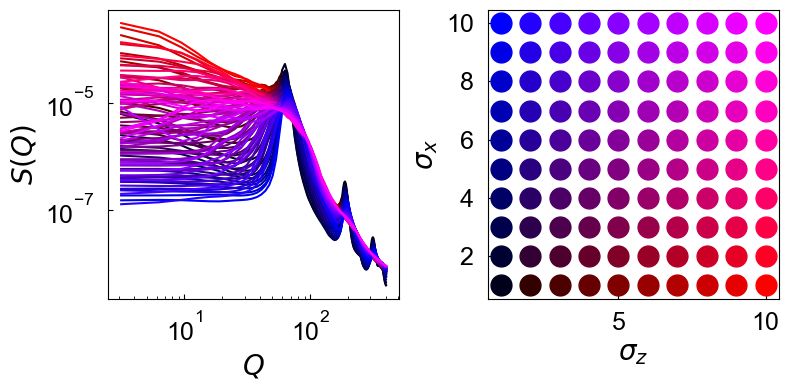

In [7]:
## plot results
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)

for i in range(len(k_grid)):
    h = np.arctan2((k_grid[i][0]-1),(k_grid[i][1]-1))/np.pi*2/3+2/3
    s = 1
    v = np.max([k_grid[i][0]/10,k_grid[i][1]/10])

    color = colorsys.hsv_to_rgb(h,s,v)

    
    # ax.plot(qq[1:],S_q_kxy[i,1:],'-',color=color)
    ax.plot(qq[1:],S_q_kxy_sm[i,:],'-',color=color)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$S(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(1,2,2)
for i in range(len(k_grid)):
    h = np.arctan2((k_grid[i][0]-1),(k_grid[i][1]-1))/np.pi*2/3+2/3
    s = 1
    v = np.max([k_grid[i][0]/10,k_grid[i][1]/10])

    color = colorsys.hsv_to_rgb(h,s,v)

    
    ax.plot(k_grid[i][0],k_grid[i][1],'.',color=color,ms=30)

ax.set_xlabel(r'$\sigma_{z}$',fontsize=20)
ax.set_ylabel(r'$\sigma_{x}$',fontsize=20)
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)



plt.tight_layout()
plt.show()

## GPR

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

In [9]:
zscore = lambda X: np.array([(x-np.mean(x))/np.std(x) for x in X])
f_F = lambda x: np.log(x)#-np.mean(np.log(x),axis=0) # N by 80
index_Q_u = (qq<250)
F_sm = zscore(f_F(S_q_kxy_sm[:,index_Q_u[1:]]))
F = zscore(f_F(S_q_kxy[:,index_Q_u]))

### LML landscape

In [10]:
X = F_sm
Y_0 = k_grid[:,0]
Y_1 = k_grid[:,1]
Y_0_std = np.std(Y_0)
Y_1_std = np.std(Y_1)

kernel = RBF(1) + WhiteKernel(1)
gp_0 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, optimizer=None).fit(X, Y_0)
gp_1 = GaussianProcessRegressor(kernel=kernel, alpha=0.0, optimizer=None).fit(X, Y_1)

lmbda = np.logspace(-0.5, 1.5, 41)
sigma = np.logspace(-3, 1, 41)

Lmbda, Sigma = np.meshgrid(lmbda, sigma)
LML_0 = [[gp_0.log_marginal_likelihood(np.log([Lmbda[i, j], Sigma[i, j]]))
        for i in range(Lmbda.shape[0])]
        for j in range(Lmbda.shape[1])]
LML_0 = np.array(LML_0).T

LML_1 = [[gp_1.log_marginal_likelihood(np.log([Lmbda[i, j], Sigma[i, j]]))
        for i in range(Lmbda.shape[0])]
        for j in range(Lmbda.shape[1])]
LML_1 = np.array(LML_1).T

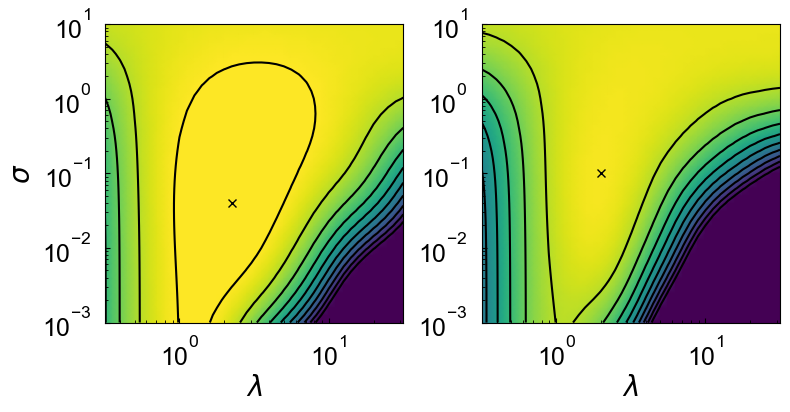

In [11]:
#### plotting
fig = plt.figure(figsize=(8,4))#,dpi=192)

## k_z
ax = fig.add_subplot(1, 2, 1)
ax.set_aspect(0.5)

levels = np.linspace(-2e3,-2e2,10)

index = np.argmax(LML_0)
index_arr_0 = np.unravel_index(index, LML_0.shape)

ax.plot(Lmbda[index_arr_0],Sigma[index_arr_0], 'xk')

ax.contour(Lmbda, Sigma, LML_0, levels, colors='k', linestyles='-')
ax.pcolormesh(Lmbda, Sigma, LML_0, shading='gouraud', vmin = -2e3, vmax = -2e2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\lambda$',fontsize=20)
ax.set_ylabel(r'$\sigma$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

## k_x
ax = fig.add_subplot(1, 2, 2)
ax.set_aspect(0.5)

levels = np.linspace(-2e3,-2e2,10)

index = np.argmax(LML_1)
index_arr_1 = np.unravel_index(index, LML_1.shape)

ax.plot(Lmbda[index_arr_1],Sigma[index_arr_1], 'xk')

ax.contour(Lmbda, Sigma, LML_1, levels, colors='k', linestyles='-')
ax.pcolormesh(Lmbda, Sigma, LML_1, shading='gouraud', vmin = -2e3, vmax = -2e2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\lambda$',fontsize=20)
# ax.set_ylabel(r'$\sigma$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()

### Train GPR model

In [12]:
kernel_0 = RBF(Lmbda[index_arr_0], (1e0, 1e1)) + WhiteKernel(Sigma[index_arr_0], (2e-2,2e-1))
gp_opt_0 = GaussianProcessRegressor(kernel=kernel_0, alpha=0.0, n_restarts_optimizer=10)
gp_opt_0.fit(X, Y_0)

kernel_1 = RBF(Lmbda[index_arr_1], (1e0, 1e1)) + WhiteKernel(Sigma[index_arr_1], (2e-2,2e-1))
gp_opt_1 = GaussianProcessRegressor(kernel=kernel_1, alpha=0.0, n_restarts_optimizer=10)
gp_opt_1.fit(X, Y_1)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=2) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=10)

### Prediction

In [13]:
# X_fit = f_F(S_q_kxy[:,1:])
X_fit = F_sm
k_grid_pred_0, k_grid_std_0 = gp_opt_0.predict(X_fit,return_std=True)
k_grid_pred_1, k_grid_std_1 = gp_opt_1.predict(X_fit,return_std=True)

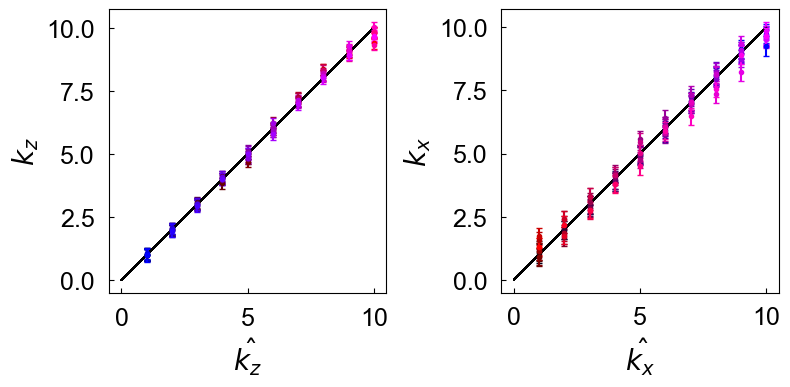

In [14]:
## plot results
fig = plt.figure(figsize=(8,4))

## k_z
ax = fig.add_subplot(1,2,1)
ax.set_aspect(1)
for i in range(len(k_grid)):
    h = np.arctan2((k_grid[i][0]-1),(k_grid[i][1]-1))/np.pi*2/3+2/3
    s = 1
    v = np.max([k_grid[i][0]/10,k_grid[i][1]/10])

    color = colorsys.hsv_to_rgb(h,s,v)

    ax.plot([0,10],[0,10],'-k',lw=1)
    ax.errorbar(k_grid[i,0],k_grid_pred_0[i],k_grid_std_0[i],capsize=2,color=color,zorder=2)
    ax.plot(k_grid[i,0],k_grid_pred_0[i],'.',color=color,zorder=3)
    

ax.set_xlabel(r'$\hat{k_z}$',fontsize=20)
ax.set_ylabel(r'$k_z$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

## k_x
ax = fig.add_subplot(1,2,2)
ax.set_aspect(1)
for i in range(len(k_grid)):
    h = np.arctan2((k_grid[i][0]-1),(k_grid[i][1]-1))/np.pi*2/3+2/3
    s = 1
    v = np.max([k_grid[i][0]/10,k_grid[i][1]/10])

    color = colorsys.hsv_to_rgb(h,s,v)

    ax.plot([0,10],[0,10],'-k',lw=1)
    ax.errorbar(k_grid[i,1],k_grid_pred_1[i],k_grid_std_1[i],capsize=2,color=color,zorder=2)
    ax.plot(k_grid[i,1],k_grid_pred_1[i],'.',color=color,zorder=3)
    

ax.set_xlabel(r'$\hat{k_x}$',fontsize=20)
ax.set_ylabel(r'$k_x$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()

## Load Experiment data

In [15]:
import os
data_path = './Data/L62_Temp/'
filename_list = os.listdir(data_path)

data_list = []
for filename in filename_list:
    data = np.loadtxt(data_path + filename, skiprows=1, delimiter='\t')
    data_list.append(data)

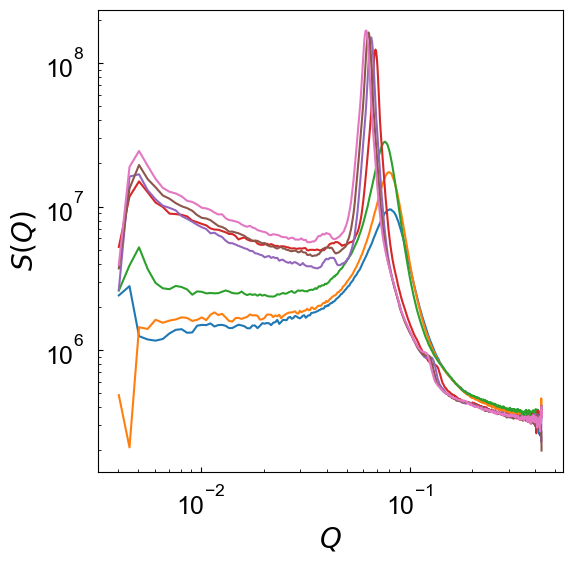

In [16]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for data in data_list:
    Q = data[:,0]
    IQ = data[:,1]
    IQ_err = data[:,2]
    ax.plot(Q, IQ, label=data[0])

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$S(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.show()

### Trim the data

In [17]:
from scipy import interpolate

0.0802776
0.0797727
0.0762385
0.0686651
0.0651309
0.0636162
0.0621015


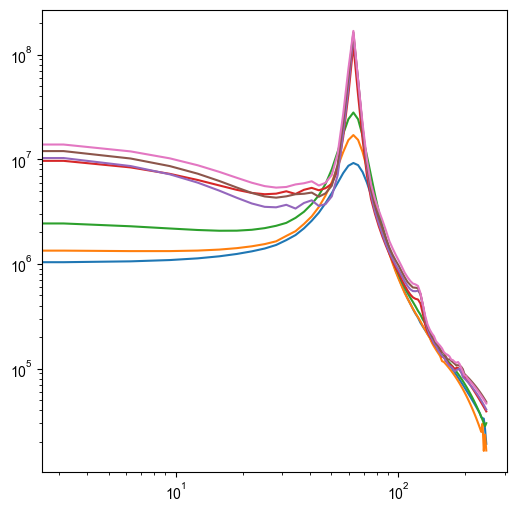

In [18]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

IQ_list = []
for data in data_list:
    Q_in = data[:,0]
    IQ_in = data[:,1]
    IQ_err_in = data[:,2]
    ## trim low Q
    index_Q = Q_in>7e-3
    Q = Q_in[index_Q]
    IQ = IQ_in[index_Q]
    IQ_err = IQ_err_in[index_Q]

    ## extend low Q
    index_low_Q = Q<3.5e-2
    Q_low_Q = Q[index_low_Q]
    IQ_low_Q = IQ[index_low_Q]
    coeff = np.polyfit(Q_low_Q, IQ_low_Q, 2)
    p = np.poly1d(coeff)
    IQ[index_low_Q] = p(Q_low_Q)

    ## substrate background
    index_high_Q = Q>3.5e-1
    IQ_high_Q = IQ[index_high_Q]
    I_bg = np.mean(IQ_high_Q)
    IQ = IQ - I_bg

    ## extend high Q
    index_high_Q = (Q>2e-1)*(Q<3e-1)
    Q_high_Q = Q[index_high_Q]
    IQ_high_Q = IQ[index_high_Q]
    coeff = np.polyfit(Q_high_Q, np.log(IQ_high_Q), 2)
    p = np.poly1d(coeff)
    IQ[index_high_Q] = np.exp(p(Q_high_Q))

    ## peak_position
    index_Q_max = np.argmax(IQ)
    Q_max = Q[index_Q_max]
    print(Q_max)
    Q_rs = Q/Q_max*np.pi*20
    f_interp = interpolate.interp1d(Q_rs, IQ, kind='cubic',fill_value='extrapolate')
    IQ_interp = f_interp(qq)
    IQ_interp[IQ_interp<0] = 1e4

    IQ_list.append(IQ_interp)
    ax.plot(qq[qq<=250], IQ_interp[qq<=250], label=data[0])
ax.set_yscale('log')
ax.set_xscale('log')

### Prediction

In [19]:
IQ_list = np.array(IQ_list)
F_data = zscore(f_F(IQ_list[:,index_Q_u]))

In [20]:
X_fit = F_data[:,1:]
k_grid_pred_0, k_grid_std_0 = gp_opt_0.predict(X_fit,return_std=True)
k_grid_pred_1, k_grid_std_1 = gp_opt_1.predict(X_fit,return_std=True)

In [21]:
k_grid_pred = np.array(list(zip(k_grid_pred_0,k_grid_pred_1)))
k_grid_std = np.array(list(zip(k_grid_std_0,k_grid_std_1)))

## Reproduce S(Q) from prediction

In [22]:
from randomwave import *

In [24]:
n_wave = 30
n_sample = 10
alpha = 0

S_q_kxy_reg = []
for k in k_grid_pred:
    print(k)
    k_mean = np.array([0,0,20])*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([k[1],k[1],k[0]])*np.pi)**2
    k_cov  = np.diagflat(k_var)
    
    #### Meshgrid ####
    grid_f = 1
    n_grid = 100*grid_f
    x = np.linspace(-1*grid_f,1*grid_f,n_grid*grid_f+1)
    y = np.linspace(-1*grid_f,1*grid_f,n_grid*grid_f+1)
    z = np.linspace(-1*grid_f,1*grid_f,n_grid*grid_f+1)
    
    r_grid = np.meshgrid(x,y,z) 

    S_q_list = []

    for i in trange(n_sample):
        # create sample
        rho = sample_wave(r_grid,k_mean,k_cov,n_wave = n_wave)

        # calculate scattering function
        box_size = 2*grid_f
        n_grid_scale = 256*grid_f
        scale = n_grid_scale/rho.shape[0]
        dq = 2*np.pi/box_size
        qq = np.arange(n_grid_scale/2)*dq

        S_q_i = scatter_grid(rho,alpha,qq,scale=scale)
        S_q_list.append(S_q_i)

    S_q = np.mean(np.array(S_q_list),axis=0)
    S_q_kxy_reg.append(S_q)

S_q_kxy_reg = np.array(S_q_kxy_reg)

#### save data ####
k_grid = np.array([k for k in zip(kz_grid.flatten(),kxy_grid.flatten())])
filename = 'S_q_kxy_reg.mat'
mdict = {'S_q_kxy_reg':S_q_kxy_reg,'k_grid':k_grid_pred,'k_std':k_grid_std}
savemat(filename,mdict)

[5.18227184 8.67244591]


100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


[4.76796724 7.82086611]


100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


[4.55450285 7.1155984 ]


100%|██████████| 10/10 [01:42<00:00, 10.28s/it]


[4.1781669 4.3029198]


100%|██████████| 10/10 [01:43<00:00, 10.35s/it]


[3.41730804 4.20926456]


100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


[3.55054683 4.11144251]


100%|██████████| 10/10 [01:42<00:00, 10.27s/it]


[4.00889339 4.54485013]


100%|██████████| 10/10 [01:42<00:00, 10.22s/it]


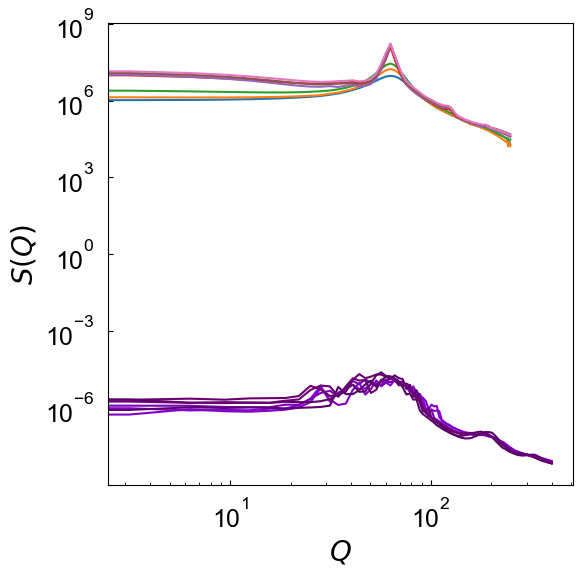

In [33]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for i, IQ in enumerate(IQ_list):
    h = np.arctan2((k_grid_pred[i][0]-1),(k_grid_pred[i][1]-1))/np.pi*2/3+2/3
    s = 1
    v = np.max([k_grid_pred[i][0]/10,k_grid_pred[i][1]/10])

    color = colorsys.hsv_to_rgb(h,s,v)
    ax.plot(qq[qq<=250], IQ[qq<=250], '')

    IQ_reg = S_q_kxy_reg[i,:]
    ax.plot(qq, IQ_reg, '-', color=color)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$S(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)